In [0]:
!pip install arviz

In [3]:
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import os
from google.colab import drive
drive.mount('/content/gdrive')
working_directory = 'My Drive/DataAnalytics/'
wd="/content/gdrive/" + working_directory
os.chdir(wd)
import stan_utility

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive/DataAnalytics


**1. Gamma distribution**

In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#prepare data
gamma1 = np.random.gamma(2.,size=10000)
gamma2 = np.random.gamma(4.,size=10000)
gamma3 = np.random.gamma(2.,4.,size=10000)
#create dict
gamma_dict={"gamma1":gamma1, "gamma2":gamma2, "gamma3":gamma3}
#create dataframe
gamma_df=pd.DataFrame.from_dict(gamma_dict)
#reshape data
gamma_melt = gamma_df.melt()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


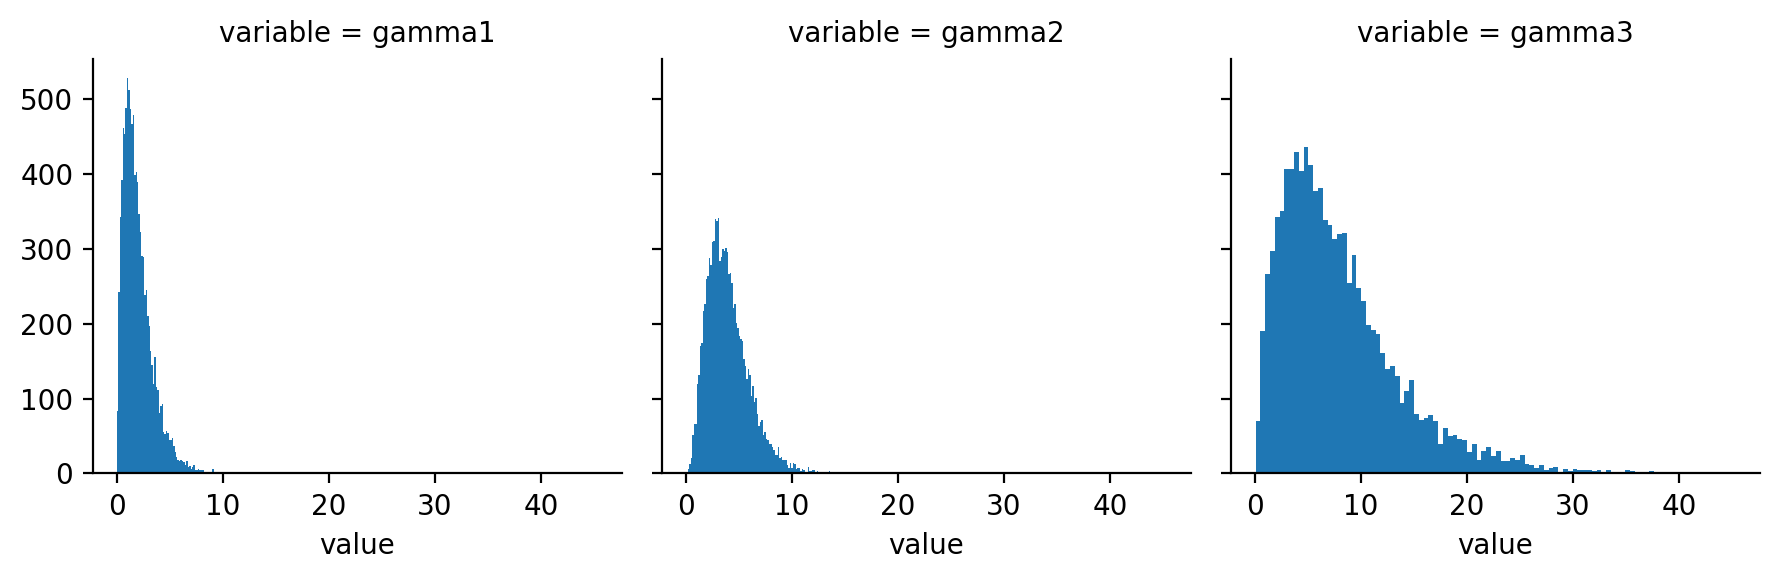

In [81]:
#plot
plot=sns.FacetGrid(gamma_melt, col="variable", sharex=True, col_wrap=3)
plot.map(plt.hist,"value",cumulative=False,bins=100)

gamma distribution using stan

In [24]:
with open('prior_tune_gamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;
    // At the end we will receive distribution from 5 to 10 with 98% probability
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.99;
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.01;
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 98% probabilty from 5 to 10
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-3, 1e3); // last 3 parameters are tolerances, middle one was changed due to occuring error

  print("Alpha  = ", y[1]);
  print("Beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2]

In [25]:
model_prior=stan_utility.compile_model('prior_tune_gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b463e87447b3ced6917ff8d266d669dd NOW.


In [98]:
y_guess=np.array([1,0.1])
theta=np.array([15,5])
data=dict(y_guess=y_guess,theta=theta)
model_prior2 = model_prior.sampling(data=data, algorithm="Fixed_param", iter=1, warmup=0, chains=1, seed=1052020)
beta = np.round(model_prior2.extract()['beta'][0])
alpha = np.round(model_prior2.extract()['alpha'][0])
print('Alpha: {a}, Beta: {b}'.format(a=alpha, b=beta))

Alpha: 19.0, Beta: 2.0


In [54]:
with open('gamma2.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha; // Shape
    real<lower=0> beta; // Inverse scale
}

parameters {
    real y;
}

model {
    y ~ gamma(alpha, beta);
}


In [37]:
gamma_model = stan_utility.compile_model('gamma2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0dacbfea3c42e5d0066eb14397d3440 NOW.


In [99]:
gamma_sampled = gamma_model.sampling(data={'alpha': alpha,
                                           'beta': beta},
                                     iter=10000,
                                     chains=1,
                                     seed=42342)
print(alpha, beta)

19.0 2.0


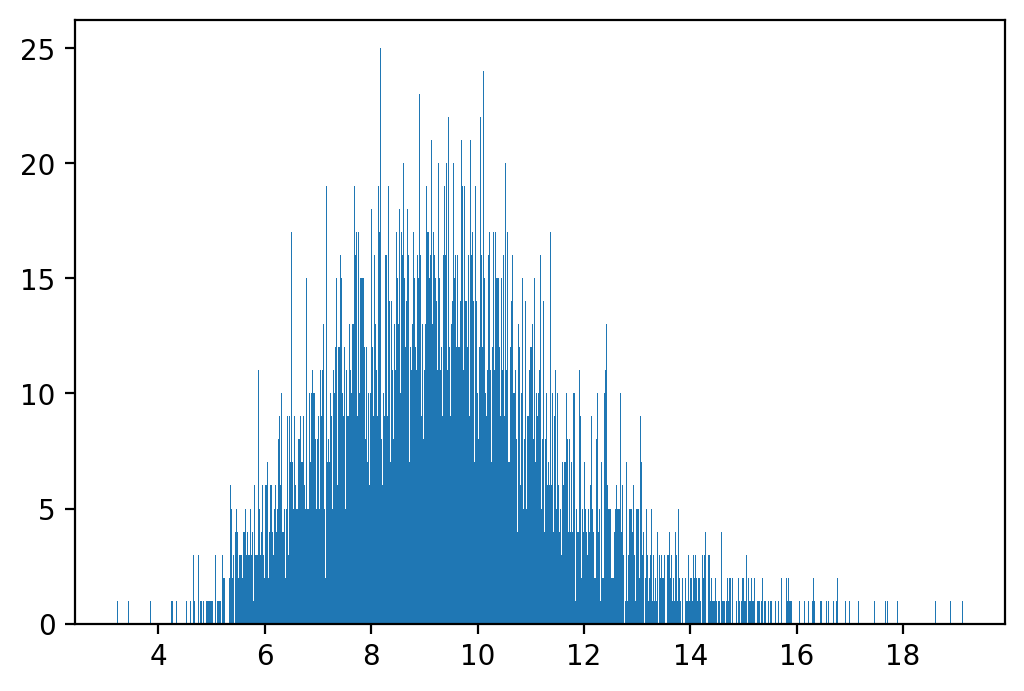

In [100]:
gamma_dist = gamma_sampled.extract()
gamma_plot = plt.hist(gamma_dist['y'], bins=1000)

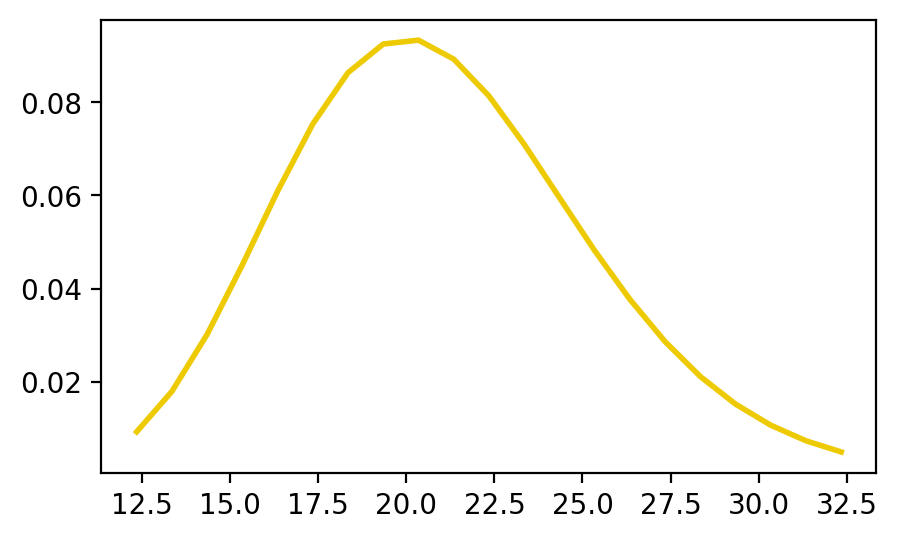

In [101]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
x = np.arange(stats.gamma.ppf(0.01, alpha, beta),
              stats.gamma.ppf(0.99, alpha, beta))
axes.plot(x,stats.gamma.pdf(x,alpha,beta),color=dark,linewidth=2)

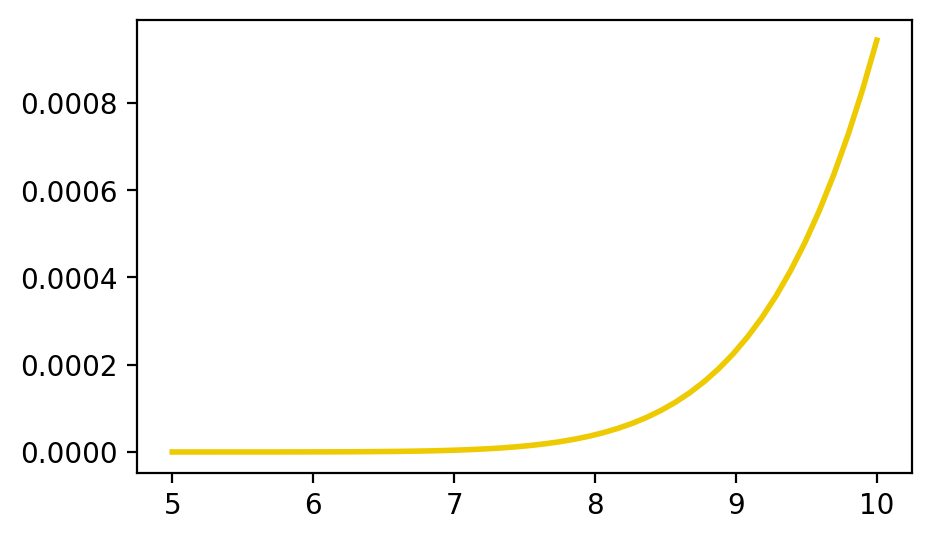

In [59]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(5,10)
axes.plot(x,stats.gamma.pdf(x,alpha,beta),color=dark,linewidth=2)

Inverse gamma dist. using stan

In [0]:
with open('prior_tune_invgamma.stan', 'r') as file:
    print(file.read())

In [71]:
model_prior_invgamma=stan_utility.compile_model('prior_tune_invgamma.stan')

Using cached StanModel


In [69]:
y_guess=np.array([0.1,0.1])
theta=np.array([10,5])
data=dict(y_guess=y_guess,theta=theta)
model_prior3 = model_prior_invgamma.sampling(data=data, algorithm="Fixed_param", iter=1, warmup=0, chains=1, seed=1052020)
alpha_inv = np.round(model_prior3.extract()['alpha'][0])
beta_inv = np.round(model_prior3.extract()['beta'][0])
print('Alpha (invgamma): {a}, Beta (invgamma): {b}'.format(a=alpha_inv, b=beta_inv))

Alpha (invgamma): 47.0, Beta (invgamma): 322.0


In [0]:
with open('gamma_inv.stan', 'r') as file:
    print(file.read())

In [73]:
gamma_model_inv = stan_utility.compile_model('gamma_inv.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b22410923ab24784a0f23ef059aeeb4 NOW.


In [0]:
gamma_sampled_inv = gamma_model_inv.sampling(data={'alpha': alpha_inv,'beta': beta_inv},iter=10000,chains=1,seed=42342)

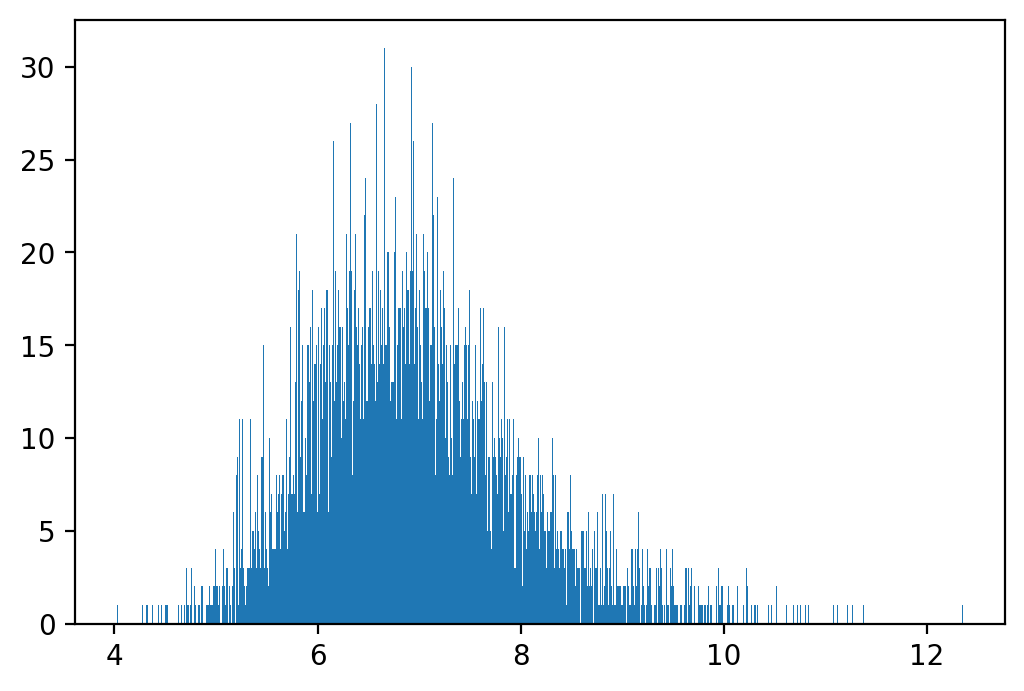

In [77]:
gamma_dist_inv = gamma_sampled_inv.extract()
gammaPlot_inv = plt.hist(gamma_dist_inv['y'], bins=1000)

**2. Negative binomial distribution**

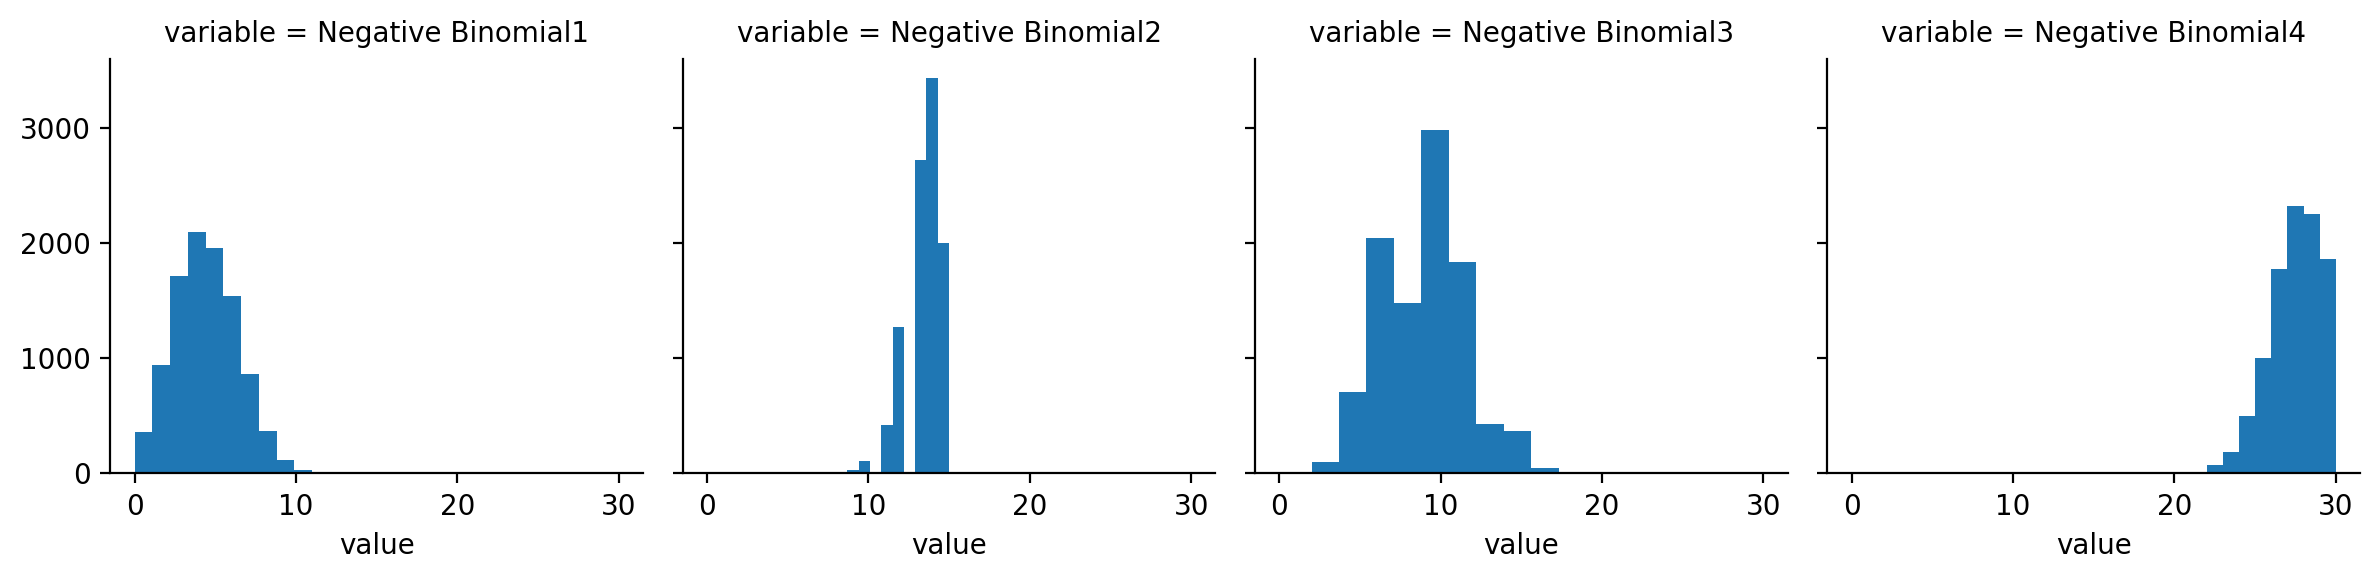

In [85]:
#binomial
size = 10000
binomial_dict = {
    "Binomial1": np.random.binomial(15, 0.3, size),
    "Binomial2": np.random.binomial(15, 0.9, size),
    "Binomial3": np.random.binomial(30, 0.3, size),
    "Binomial4": np.random.binomial(30, 0.9, size)
}

binomial_df = pd.DataFrame.from_dict(binomial_dict)
binomial_melt = binomial_df.melt()

plot = sns.FacetGrid(binomial_melt, col="variable", sharex=True, col_wrap=4)
plot.map(plt.hist, "value", cumulative=False, bins=10)

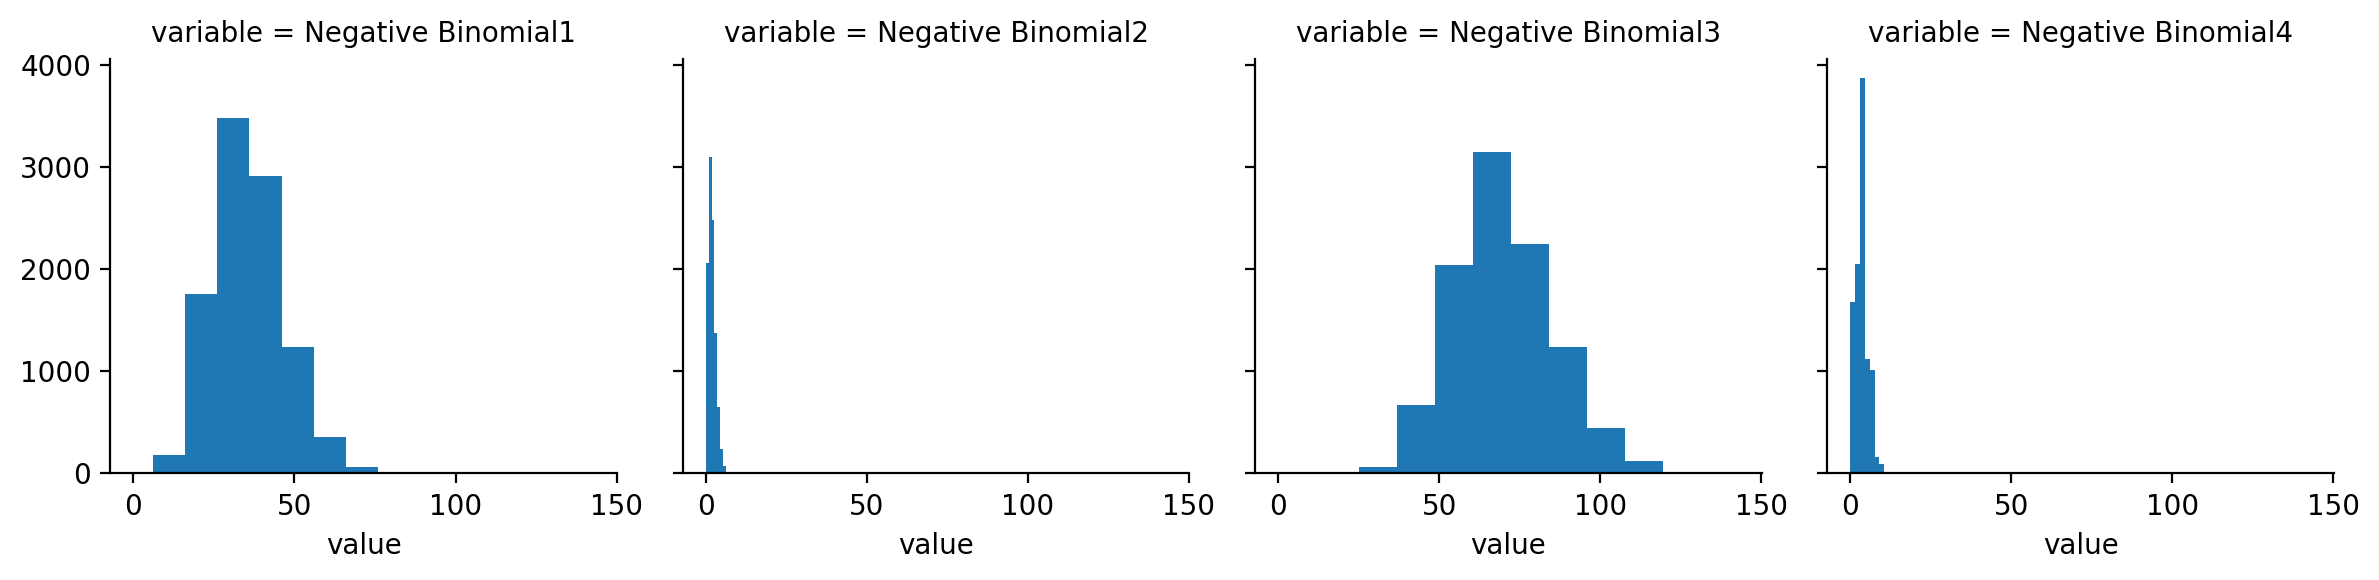

In [86]:
#negative binomial
size = 10000
nbinomial_dict = {
    "Negative Binomial1": np.random.negative_binomial(15, 0.3, size),
    "Negative Binomial2": np.random.negative_binomial(15, 0.9, size),
    "Negative Binomial3": np.random.negative_binomial(30, 0.3, size),
    "Negative Binomial4": np.random.negative_binomial(30, 0.9, size)
}

nbinomial_df = pd.DataFrame.from_dict(nbinomial_dict)
nbinomial_melt = nbinomial_df.melt()

plot = sns.FacetGrid(nbinomial_melt, col="variable", sharex=True, col_wrap=4)
plot.map(plt.hist, "value", cumulative=False, bins=10)

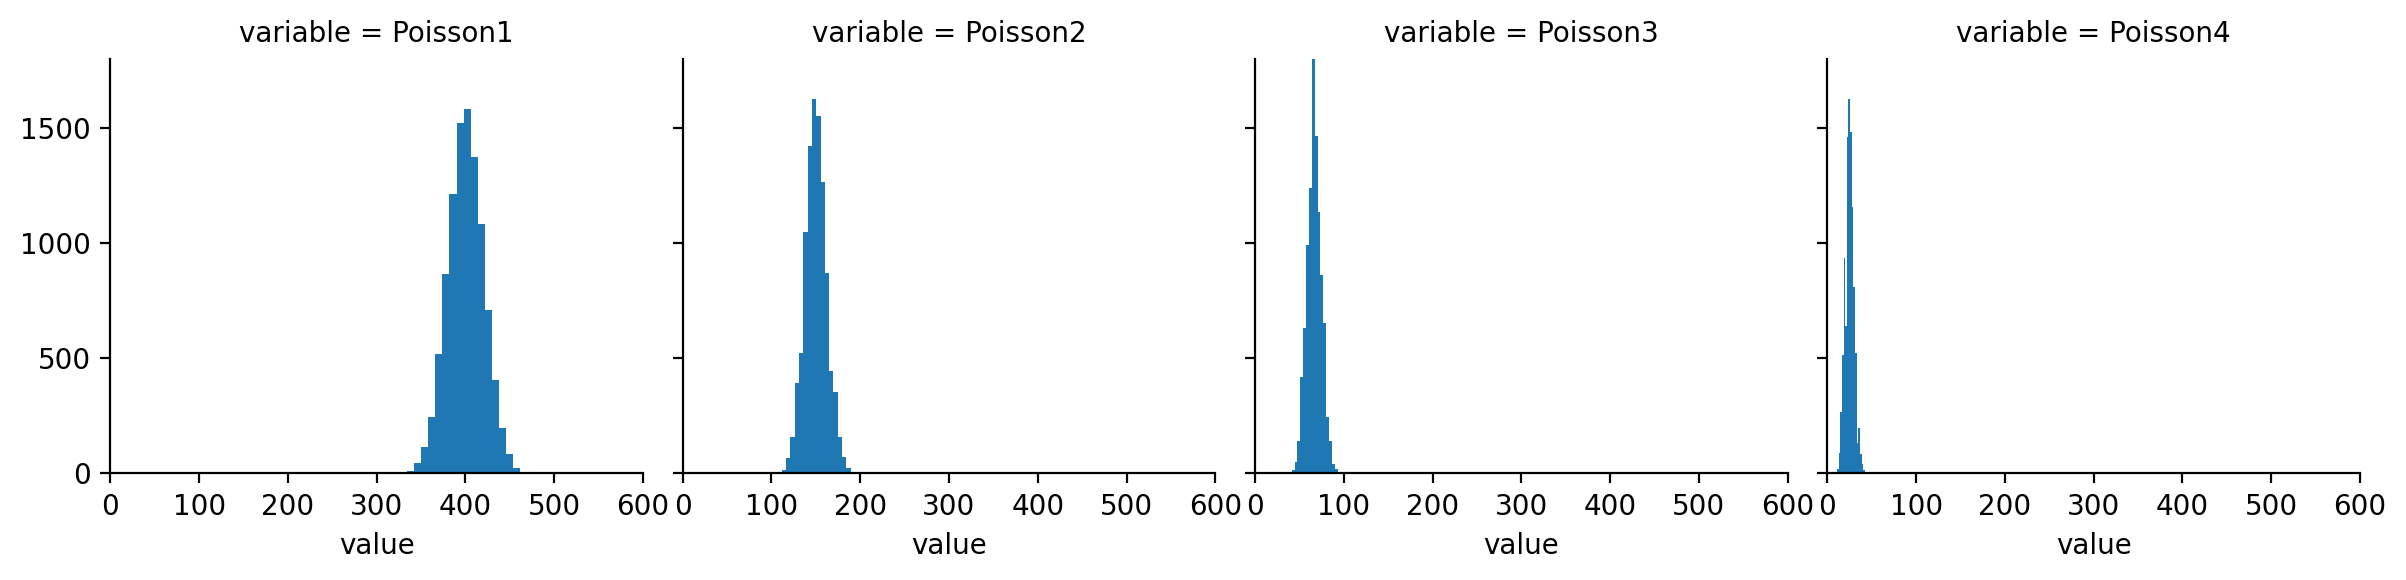

In [108]:
#poisson dist

p=[0.2,0.4,0.6,0.8]
n=100
u=[stats.nbinom.mean(n, x) for x in p]

Poisson_dict_comp = {
    "Poisson1".format(u[0]): np.random.poisson(u[0], size=size),
    "Poisson2".format(u[1]): np.random.poisson(u[1], size=size),
    "Poisson3".format(u[2]): np.random.poisson(u[2], size=size),
    "Poisson4".format(u[3]): np.random.poisson(u[3], size=size)
}
Poisson_df_comp = pd.DataFrame.from_dict(Poisson_dict_comp)
melted_Poisson_comp = Poisson_df_comp.melt()

Graph = sns.FacetGrid(melted_Poisson_comp, col="variable", sharex=True, col_wrap=4)
Graph.map(plt.hist, "value", cumulative=False, bins=20)
Graph.set(xlim=(0, 600), ylim=(0, 1800))

binomial dist. using stan

In [0]:
with open('negbinomial.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real mean_;
    real phi;
}

generated quantities {
    real negcon = neg_binomial_rng(alpha, alpha/mean_);
    real negdisc = neg_binomial_2_rng(mean_, phi);

    real poissoncon = poisson_rng(negcon);
    real poissondisc = poisson_rng(negdisc);
}


In [0]:
model_negbinomial = stan_utility.compile_model('negbinomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d47d999421d693a49472acc4beb25454 NOW.


In [0]:
data = dict(mean_=10, alpha=2, phi=2, M=1000)
model_negbinomial2 = model_negbinomial.sampling(data=data,
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [0]:
params=model_negbinomial2.extract()
negbincon=params['negcon']
poissoncon=params['poissoncon']
negbindisc=params['negdisc']
poissondics=params['poissondisc']

In [0]:
beta = data['alpha']/data['mean_']
x_con=np.linspace(0, 80, 81)
x_dis=np.linspace(0, 45, 46)
nbinom_fun_con = stats.nbinom(data['alpha'], beta/(beta+1))
nbinom_fun_dis = stats.nbinom(data['phi'], data['phi']/(data['mean_']+data['phi']))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


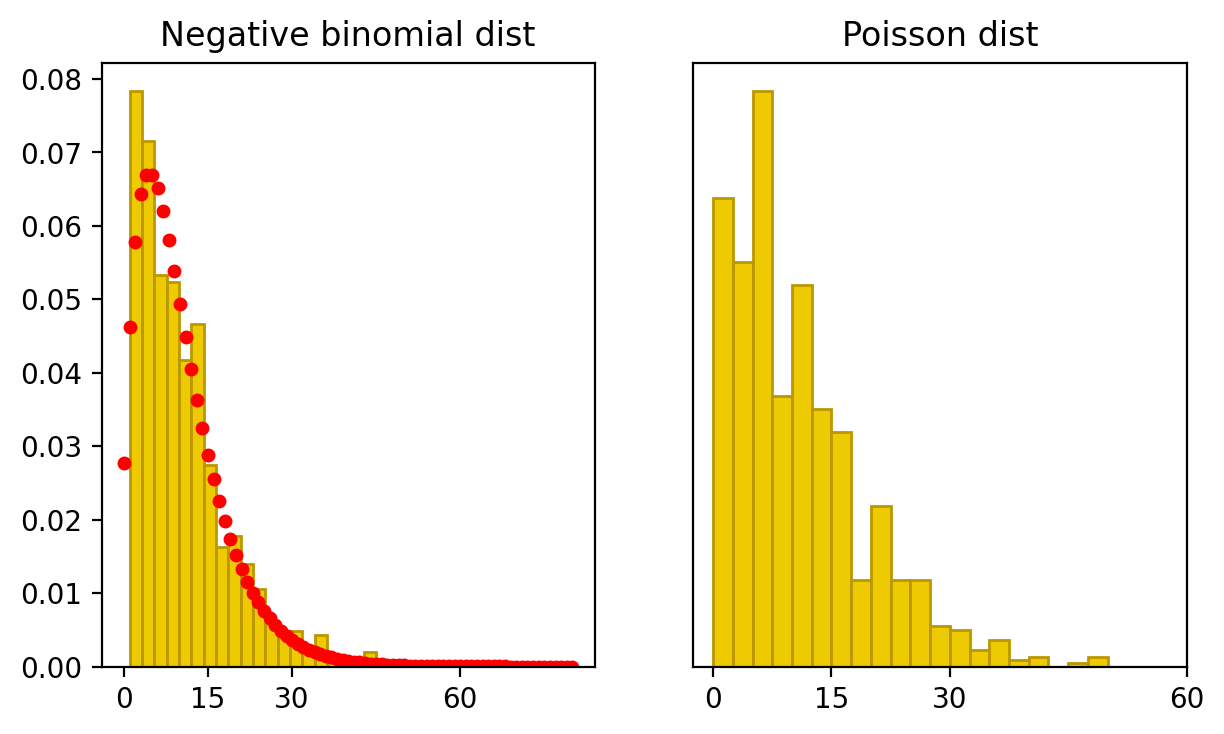

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(negbincon,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.plot(x_con, nbinom_pmf_con,'ro', markersize=4)
ax1.set_xticks([0,15,30,60])
ax1.set_title(r'Negative binomial dist')

ax2=axes[1]
ax2.hist(poissoncon,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,15,30,60])
ax2.set_title('Poisson dist')

plt.show()

**3. Student-t family distributions**

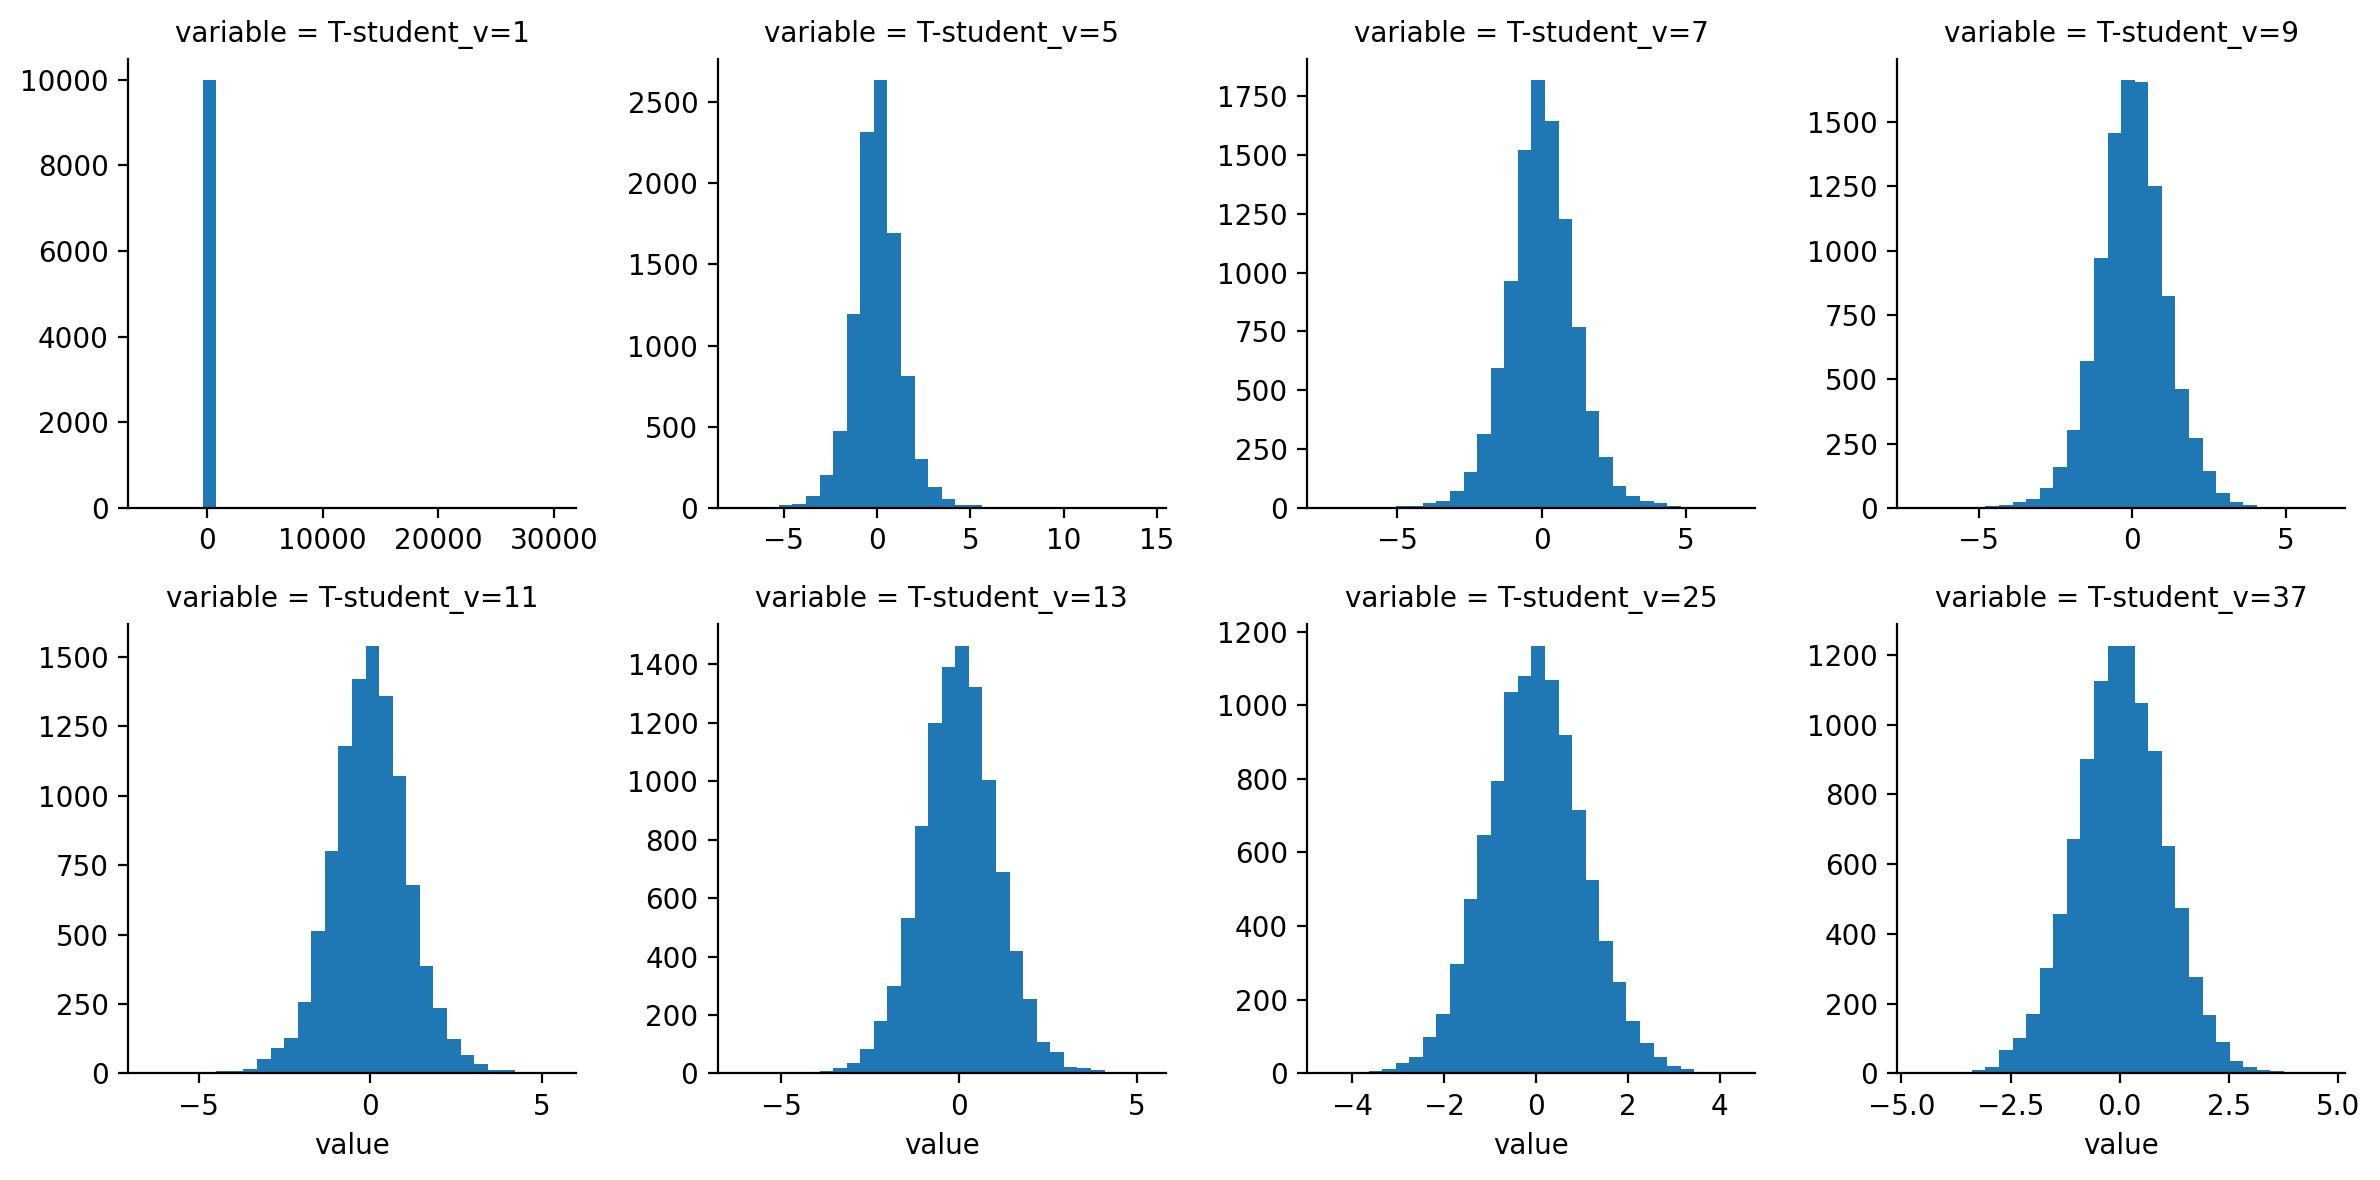

In [111]:
size = 10000
n=[1,5,7,9,11,13,25,37]
student_dict: dict = {}

for param in n:
    student_dict['T-student_v={}'.format(param)] = np.random.standard_t(param, size)

tstudent_df = pd.DataFrame.from_dict(student_dict)
melted_tstudent = tstudent_df.melt()

Graph = sns.FacetGrid(melted_tstudent, col="variable", sharey=False, sharex=False, col_wrap=4)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=30)

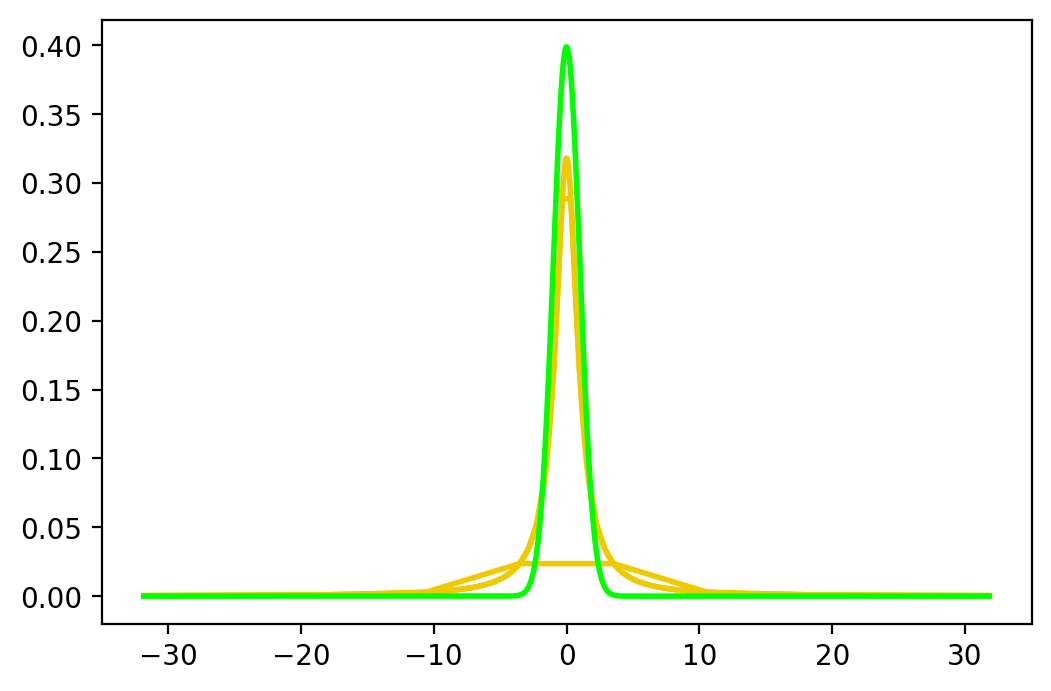

In [116]:
#cauchy distribution
samples = [10, 100, 1000]
fig, ax = plt.subplots(1, 1)
for i in range(len(samples)):
    xc = np.linspace(stats.t.ppf(0.01, n[0]),
                    stats.t.ppf(0.99, n[0]),samples[i])
    ax.plot(xc, stats.t.pdf(xc, n[0]),color=dark,linewidth=2)

ax.plot(xc, stats.norm.pdf(xc),color=green,linewidth=2)
plt.show()

student-t dist. using stan

In [117]:
with open('student_t.stan', 'r') as file:
    print(file.read())

data {
    real nu;    
    real mu;    
    real sigma; 
}

generated quantities {
    real y_sim = student_t_rng(nu, mu, sigma);
}


In [118]:
model_student_t = stan_utility.compile_model('student_t.stan')

Using cached StanModel


In [122]:
R1=10
model_student_t1 = model_student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
model_student_t2 = model_student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
print("Summary model student t1:" + model_student_t1.stansummary())
print("Summary model student t2:" + model_student_t2.stansummary())

Summary model student t1:Inference for Stan model: anon_model_3b55136f398b6ae381aa9d552d38eed5.
1 chains, each with iter=10; warmup=0; thin=1; 
post-warmup draws per chain=10, total post-warmup draws=10.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y_sim  -2.51    4.09  13.74 -38.59  -3.15  -0.12   2.68  14.92     11   0.93
lp__     0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan

Samples were drawn using Fixed_param at Mon Jun  8 15:25:42 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Summary model student t2:Inference for Stan model: anon_model_3b55136f398b6ae381aa9d552d38eed5.
1 chains, each with iter=100; warmup=0; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=100.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y_sim  -1.45    0.81   8.51 -25.83  -3.07  -0.19 

In [0]:
params1=model_student_t1.extract()
student1=params1['y_sim']

params2=model_student_t2.extract()
student2=params2['y_sim']

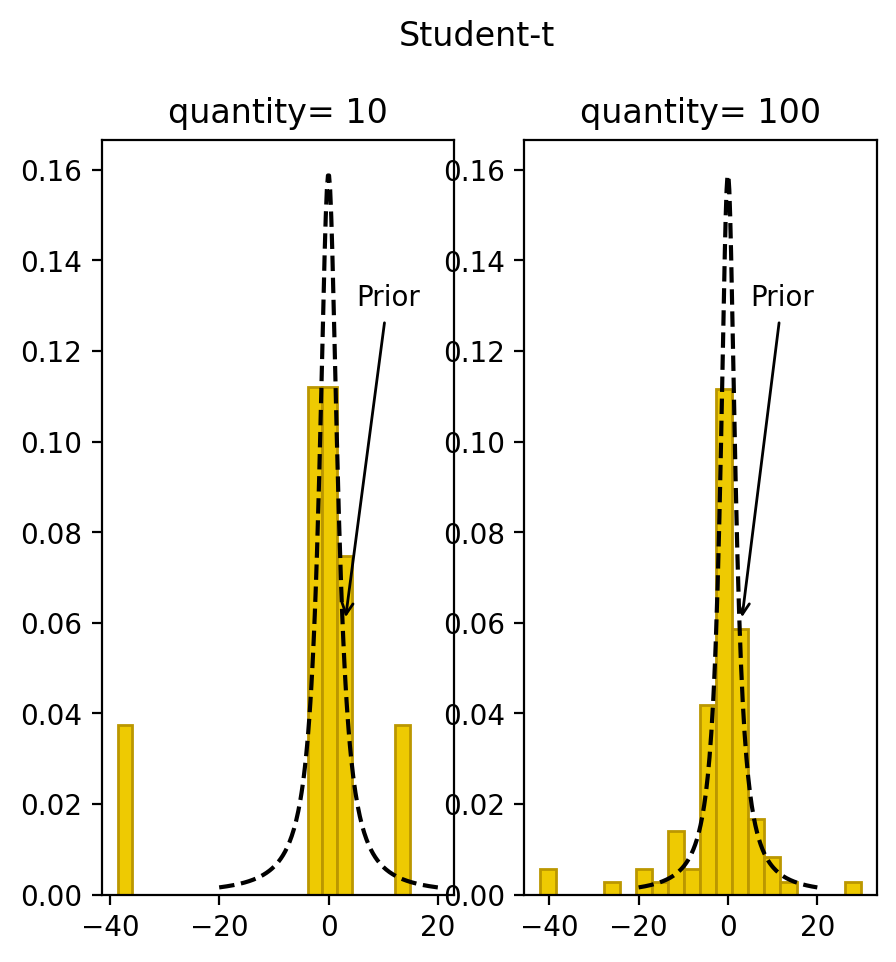

In [124]:
x=np.linspace(-20,20,200)
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
fig.suptitle('Student-t',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax1.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax2.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

See how mean and variance behave while you increase number of samples....

**4. Multivariate normal distributions**

Multivariate normal dist. by stan

In [147]:
with open('multivariatenormal.stan') as file:
    print(file.read())

data {
    vector[2] mu;       
    matrix[2,2] sigma;  
}


generated quantities {
    vector[2] result = multi_normal_rng(mu,sigma);
}


In [148]:
modelmultivariate = stan_utility.compile_model('multivariatenormal.stan')

Using cached StanModel


In [0]:
data = dict(mu=[2.0, 8], sigma=[[1, .3],[.3, 2]]) #sigma=covariance matrix
modelmultivariate2 = modelmultivariate.sampling(data=data,
                                            seed=1052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)
params_result = modelmultivariate2.extract()
y_sim = params_result['result'].T

In [0]:
y_sim0 = y_sim[0].flatten()
y_sim1 = y_sim[1].flatten()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,
         1.,  2.,  2.,  1.,  3.,  0.,  3.,  3.,  2.,  3.,  5.,  4.,  3.,
         6.,  2.,  7., 12.,  8., 13., 12.,  5.,  5., 10., 12., 12., 15.,
        18., 17., 19., 22., 21., 19., 18., 19., 24., 24., 28., 17., 18.,
        26., 18., 24., 27., 33., 30., 22., 22., 22., 22., 25., 11., 18.,
        16., 22., 19., 23., 18., 17., 12., 12., 14., 13.,  9., 12.,  7.,
         9., 12., 10.,  7.,  8.,  5.,  4.,  6.,  2.,  2.,  6.,  5.,  0.,
         3.,  2.,  2.,  1.,  0.,  1.,  0.,  1.,  1.]),
 array([-1.58487609e+00, -1.52133629e+00, -1.45779648e+00, -1.39425668e+00,
        -1.33071687e+00, -1.26717707e+00, -1.20363726e+00, -1.14009745e+00,
        -1.07655765e+00, -1.01301784e+00, -9.49478039e-01, -8.85938233e-01,
        -8.22398428e-01, -7.58858623e-01, -6.95318817e-01, -6.31779012e-01,
        -5.68239207e-01, -5.04699401e-01, -4.41159596e-01, -3.77619791e-01,
        -3.14079985e-01, -2.50540180e-01, -1.87000375e

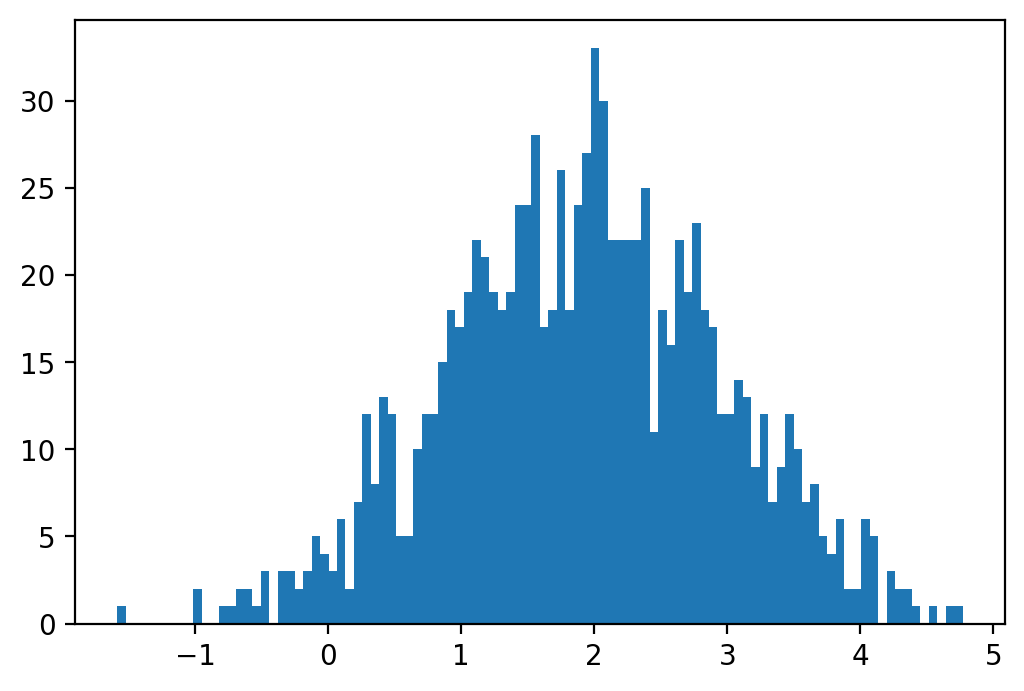

In [152]:
plt.hist(y_sim[0].flatten(), bins=100)

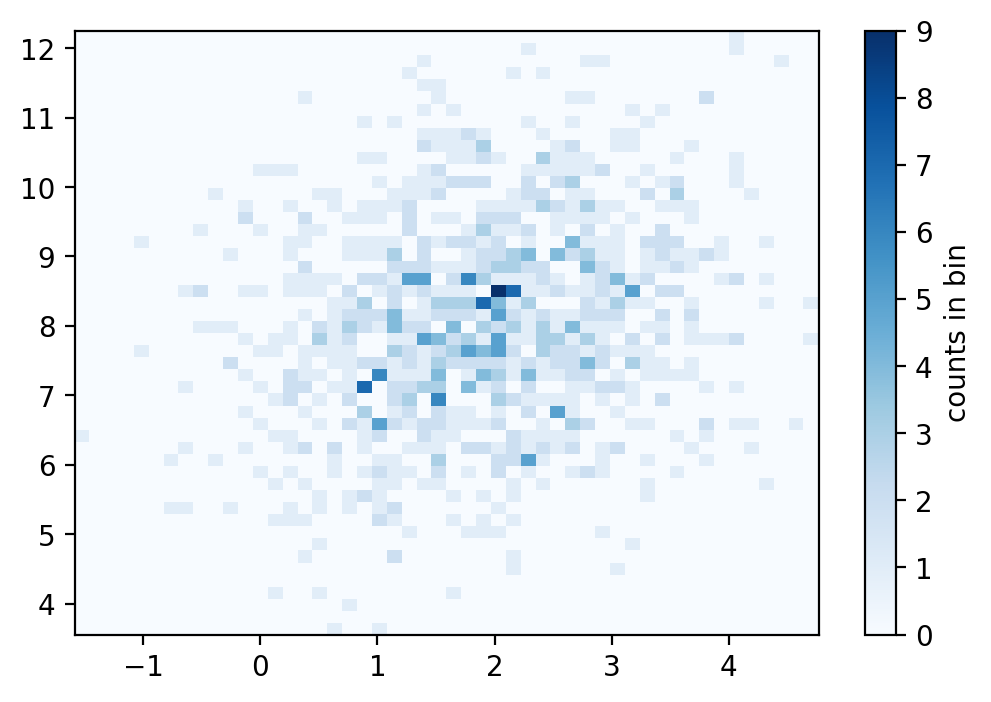

In [168]:
#2d histogram
plt.hist2d(y_sim[0].flatten(), y_sim[1].flatten(), bins=50, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution.

Higher Dimension

In [155]:
multivariate_nd_model = stan_utility.compile_model('multivariatenormal_nd.stan')

Using cached StanModel


In [0]:
mean = [0, 0, 0]
cov = [(1, .5, .3), (.5, 1, .5), (.3, .5, 1)]


multivariate_nd_sampled=multivariate_nd_model.sampling(data={'N': len(mean),
                                                       'mu': mean,
                                                       'Sigma': cov},
                                                 iter=1000,
                                                 seed=43541)

In [160]:
multivariate_nd_dist = multivariate_nd_sampled.extract()
print(multivariate_nd_dist)
print(multivariate_nd_sampled.stansummary())

OrderedDict([('y', array([[-0.59510018,  0.26179369,  1.03516126],
       [ 0.45878915,  0.43532037,  0.4926151 ],
       [ 0.49948789, -0.7489701 , -0.458326  ],
       ...,
       [ 1.53803545,  1.21623273,  1.30295355],
       [-0.68865804, -1.21383109, -0.51335853],
       [ 0.57423305,  0.68306095,  0.67547507]])), ('lp__', array([-0.99339626, -0.17839261, -0.80322005, ..., -1.58429579,
       -0.74771155, -0.33728714]))])
Inference for Stan model: anon_model_d3559db38eae9d51d79b87578e6d95ea.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y[1]   0.03    0.03   1.03  -1.96  -0.69   0.01   0.74   2.06   1193    1.0
y[2]   0.05    0.03   1.01  -1.92  -0.64   0.06   0.75   1.99   1195    1.0
y[3]   0.02    0.03   1.01  -2.06  -0.66   0.04    0.7   1.96   1334    1.0
lp__  -1.51    0.04   1.19  -4.83  -2.03  -1.21  -0.69  -0.12    866    1.0



In [163]:
#create dictionary
multivariate_nd_dict={'y_1': multivariate_nd_dist['y'][:,0],
                        'y_2': multivariate_nd_dist['y'][:,1],
                        'y_3': multivariate_nd_dist['y'][:,2]}

#create dataframe
multivariate_nd_df = pd.DataFrame(multivariate_nd_dict)
print(multivariate_nd_df)

           y_1       y_2       y_3
0    -0.595100  0.261794  1.035161
1     0.458789  0.435320  0.492615
2     0.499488 -0.748970 -0.458326
3     0.191426  0.032048  1.073130
4     0.495607  0.443470  0.040691
...        ...       ...       ...
1995 -0.417240 -0.593462  0.969807
1996  0.445259  0.328734  0.237740
1997  1.538035  1.216233  1.302954
1998 -0.688658 -1.213831 -0.513359
1999  0.574233  0.683061  0.675475

[2000 rows x 3 columns]


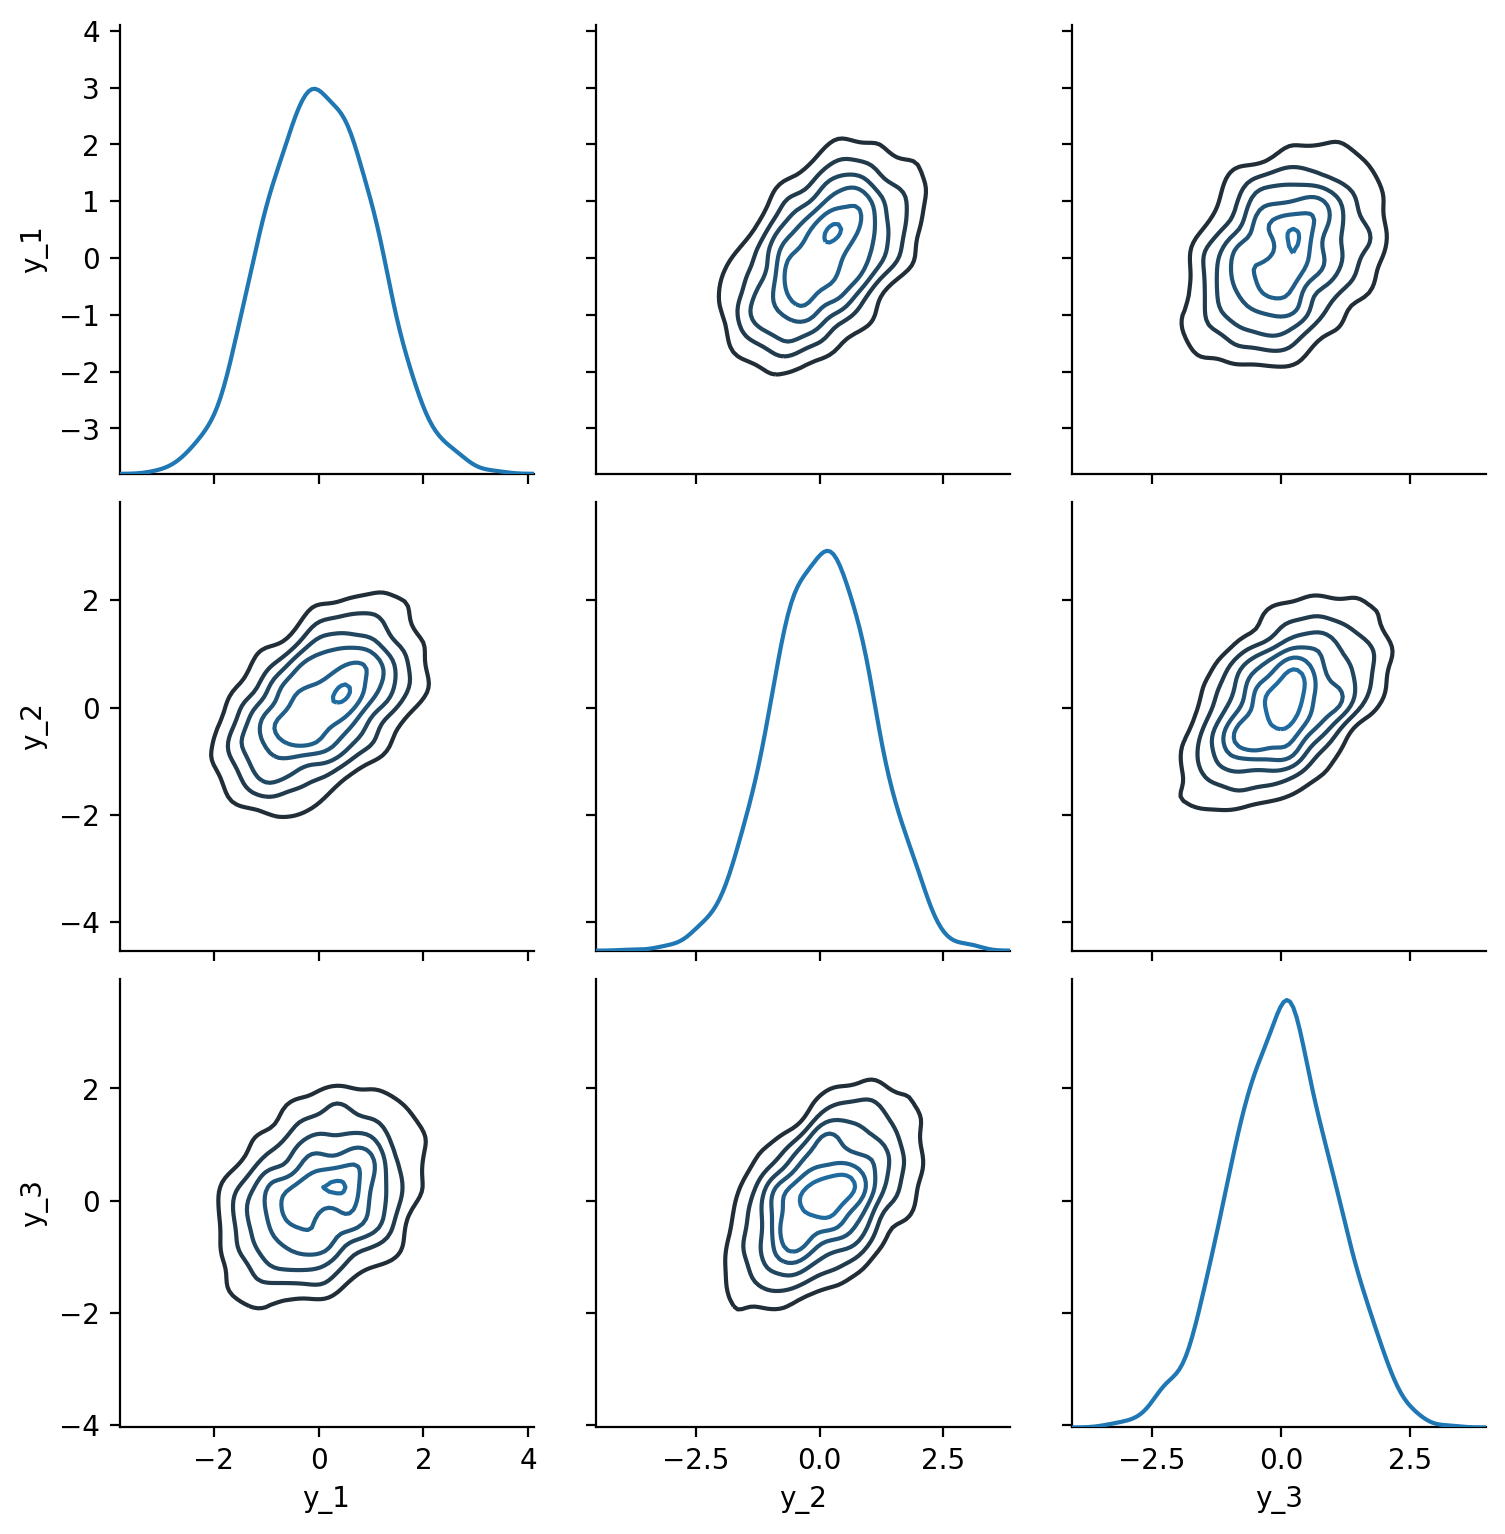

In [164]:
plot = sns.PairGrid(multivariate_nd_df)
plot.map_diag(sns.kdeplot)
plot.map_offdiag(sns.kdeplot, n_levels=6);

For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.